# LIDC-IDRI Lung Segmentation


In [1]:
import cv2
import keras
import datasets
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from PIL import Image
from dataclasses import dataclass

from models.unet import UNet

Load the dataset


In [2]:
lung_dataset = datasets.load_dataset("jmanuelc87/lidc-idri-segmentation")
lung_dataset = lung_dataset["train"].train_test_split(train_size=0.8, seed=42)  # type: ignore
lung_dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'FetchError: Could not fetch resource at https://colab.research.google.com/userdata/get?authuser=0&notebookid=https%3A%2F%2Fgithub.com%2Fjmanuelc87%2Flung-segmentation-lidc-idri%2Fblob%2Fmain%2Fnotebooks%2Flidc-idri-segmentation.ipynb&key=HF_TOKEN: 503  '.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/470 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2651 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 2120
    })
    test: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 531
    })
})

## Configuration


In [3]:
@dataclass
class TrainingConfig:
    EPOCHS: int = 200
    NUM_CLASSES: int = 1
    BATCH_SIZE: int = 32
    IMG_WIDTH: int = 192
    IMG_HEIGHT: int = 192

## Visualization

Exploration of some samples of the dataset and its masks


In [4]:
def num_to_rgb(mask):
    num_arr = np.array(mask)
    output = np.zeros(num_arr.shape[:2] + (3,))
    output[num_arr == 255] = (255, 0, 0)
    return output.astype(np.uint8)

In [5]:
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

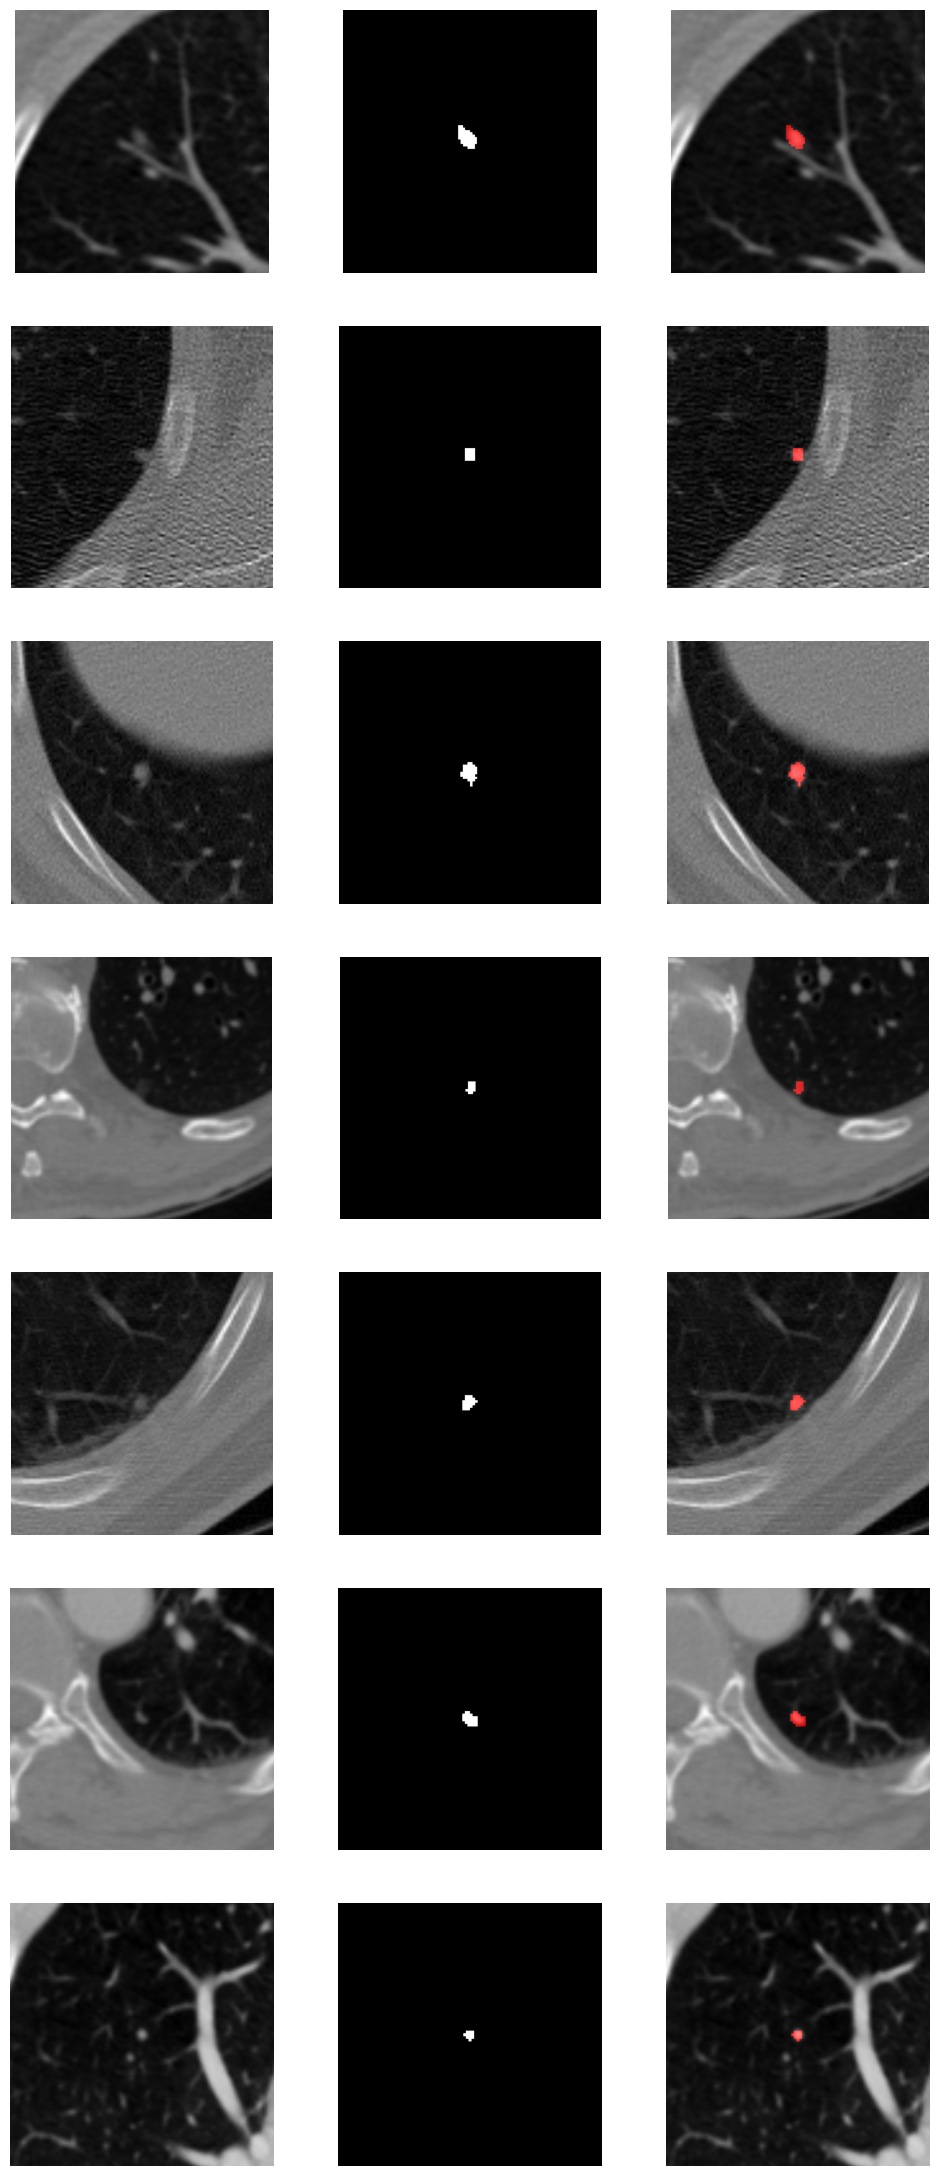

In [6]:
def plot(dataset: datasets.Dataset, qty=10):
    fig, ax = plt.subplots(qty, 3, figsize=(12, 28))

    for i, item in enumerate(dataset):
        if i >= qty:
            break

        ax[i, 0].axis("off")
        ax[i, 0].imshow(item["patch"], cmap="gray")  # type: ignore

        ax[i, 1].axis("off")
        ax[i, 1].imshow(item["patch_mask"], cmap="gray")  # type: ignore

        patch = np.array(item["patch"])  # type: ignore
        patch = np.transpose(np.stack([patch, patch, patch]), axes=(1, 2, 0))

        mask = num_to_rgb(item["patch_mask"])  # type: ignore
        image = image_overlay(patch, mask)

        ax[i, 2].axis("off")
        ax[i, 2].imshow(image, cmap="gray")


plot(lung_dataset["train"], qty=7)  # type: ignore

## Data Preparation

Preparation of the dataset using albumentations library for augmenting the dataset samples using the transformations:

- RandomCrop
- CenterCrop
- SquareSymmetry
- GaussNoise
- Normalize
- ToTensor

And creation of the train, valid and test splits for datasets and dataloaders


In [7]:
train_transforms = A.Compose(
    [
        A.Resize(
            height=TrainingConfig.IMG_HEIGHT,
            width=TrainingConfig.IMG_WIDTH,
            interpolation=cv2.INTER_NEAREST,
            p=1.0,
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
    ]
)


valid_transforms = A.Compose(
    [
        A.Resize(
            height=TrainingConfig.IMG_HEIGHT,
            width=TrainingConfig.IMG_WIDTH,
            p=1.0,
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
    ]
)

In [8]:
def map_image_transforms(transformations):

    def wrapper(row):
        augmented = []
        keys = row.keys()
        for item in zip(*row.values()):
            items = {k: np.array(v) for k, v in zip(keys, item)}
            values = transformations(**items)
            augmented.append(values)

        for key in keys:
            row[key] = [np.expand_dims(item[key], axis=-1) for item in augmented]

        return row

    return wrapper

In [9]:
# Remove the columns not needed and rename the ones needed to be interpreted by albumentations library
new_lung_dataset = (
    lung_dataset.remove_columns(["image", "image_mask", "malignancy", "cancer"])
    .rename_column("patch", "image")
    .rename_column("patch_mask", "mask")
)

In [10]:
def create_datasets(lung_dataset):
    lung_train_dataset = (
        lung_dataset["train"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(train_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
        )
    )

    tmp_dataset = lung_dataset["test"].train_test_split(train_size=0.5)

    lung_valid_dataset = (
        tmp_dataset["train"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(valid_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
        )
    )

    lung_test_dataset = (
        tmp_dataset["test"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(valid_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
        )
    )

    return lung_train_dataset, lung_valid_dataset, lung_test_dataset

In [11]:
(
    train_dataset,
    valid_dataset,
    test_dataset,
) = create_datasets(new_lung_dataset)

## Modeling

Creation of a UNet model in pytorch


In [12]:
model = UNet(num_classes=TrainingConfig.NUM_CLASSES)

model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),  # type: ignore
    metrics=["accuracy"],
)

In [13]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=6, restore_best_weights=True, verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=TrainingConfig.EPOCHS,
    callbacks=[early_stop],
)

Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.0960 - loss: 488.4368 - val_accuracy: 1.3789e-04 - val_loss: 405.1584
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 530ms/step - accuracy: 9.1985e-05 - loss: 487.7809 - val_accuracy: 1.0155e-04 - val_loss: 405.1282
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 528ms/step - accuracy: 9.4260e-05 - loss: 487.7490 - val_accuracy: 2.0176e-04 - val_loss: 405.1208
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 527ms/step - accuracy: 2.0063e-04 - loss: 487.7392 - val_accuracy: 4.2471e-04 - val_loss: 405.1133
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 528ms/step - accuracy: 4.5848e-04 - loss: 487.7313 - val_accuracy: 0.0010 - val_loss: 405.1049
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 529ms/step - accuracy: 0.0011 - loss: 487.7234 - val_accuracy: 0.0026 - val_loss: 405.0959
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 527ms/step - accuracy: 0.0025 - loss: 487.7156 - val_accuracy: 0.0063 - val_loss: 405.0867
Epoch 8/200
67/67 ━━━━━━━━━━━━━━

In [14]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [
            metrics,
        ]
        metric_name = [
            metric_name,
        ]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])  # type:ignore

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)  # type:ignore
    plt.title(ylabel)  # type:ignore
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=True)
    plt.close()

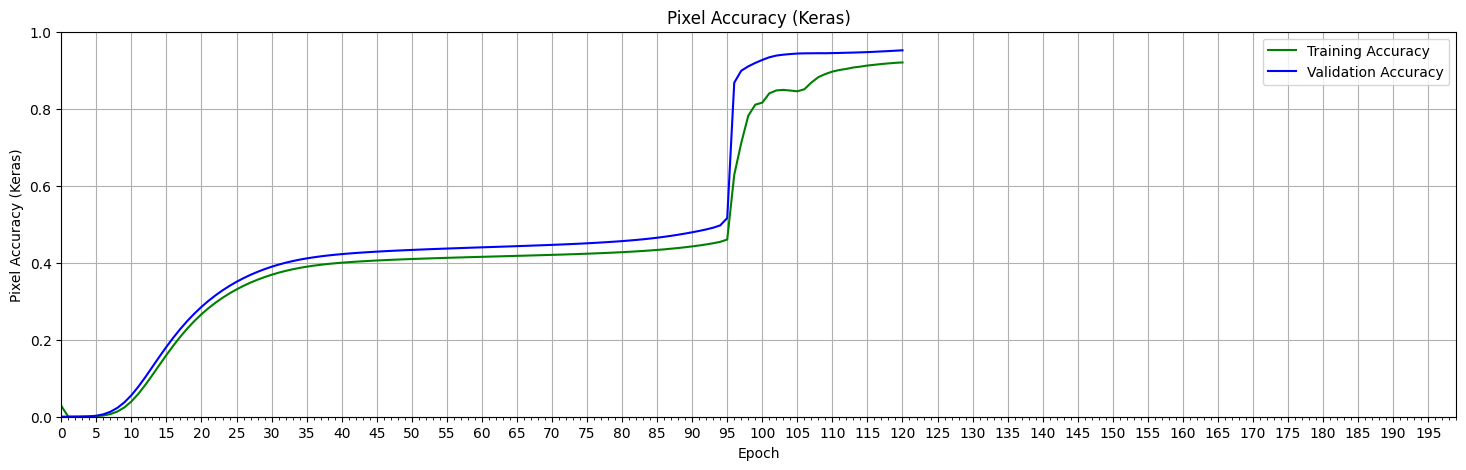

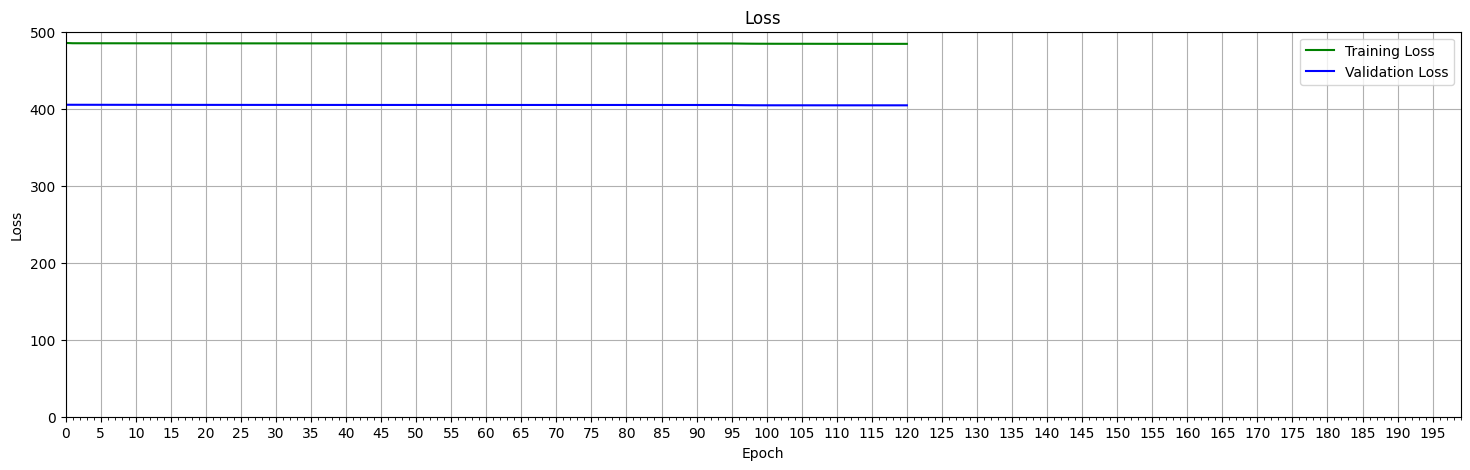

In [18]:
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

# Dice coefficient.
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]


plot_results(
    [train_acc, valid_acc],
    ylabel="Pixel Accuracy (Keras)",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 500.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

In [16]:
def inference(model, dataset):

    num_batches_to_process = 1
    tf.experimental.numpy.experimental_enable_numpy_behavior()

    for idx, data in enumerate(dataset):

        if idx == num_batches_to_process:
            break

        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype("float32")
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img * 255).astype("uint8")

        for i in range(0, len(batch_img)):

            fig = plt.figure(figsize=(20, 8))

            # Display the original image.
            ax1 = fig.add_subplot(1, 4, 1)
            ax1.imshow(batch_img[i], cmap="gray")
            ax1.title.set_text("Actual frame")
            plt.axis("off")

            # Display the ground truth mask.
            true_mask = batch_mask[i]
            ax2 = fig.add_subplot(1, 4, 2)
            ax2.set_title("Ground truth labels")
            ax2.imshow(true_mask, cmap="gray")
            plt.axis("off")

            # Display the predicted segmentation mask.
            pred_mask = pred_all[i][:, :, np.newaxis]

            print(pred_mask.shape)

            ax3 = fig.add_subplot(1, 4, 3)
            ax3.set_title("Predicted labels")
            ax3.imshow(pred_mask, cmap="gray")
            plt.axis("off")

            plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(192, 192, 1)


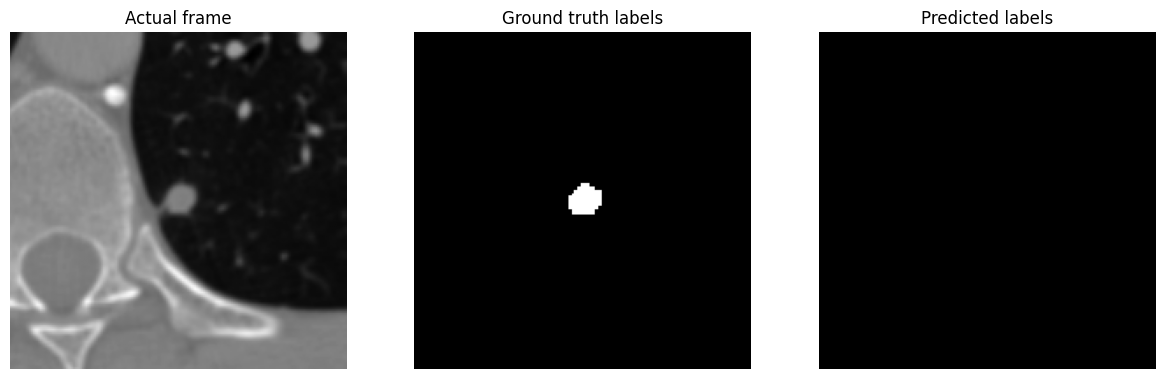

(192, 192, 1)


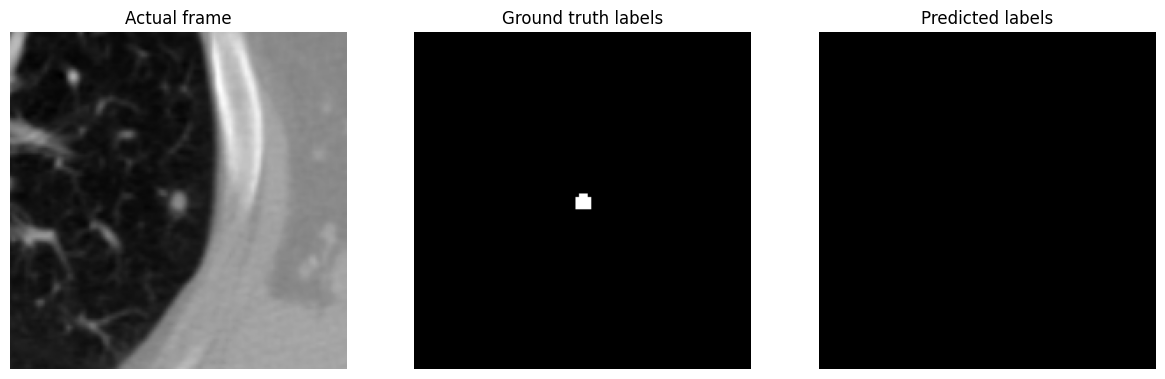

(192, 192, 1)


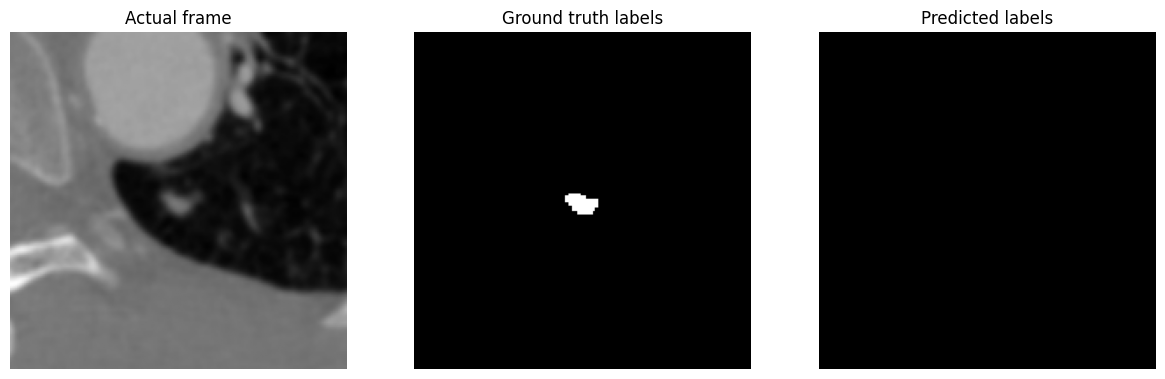

(192, 192, 1)


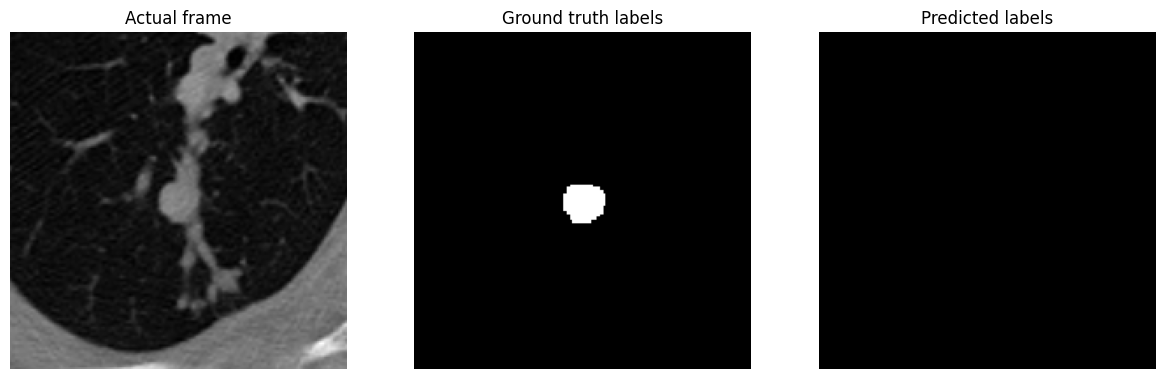

(192, 192, 1)


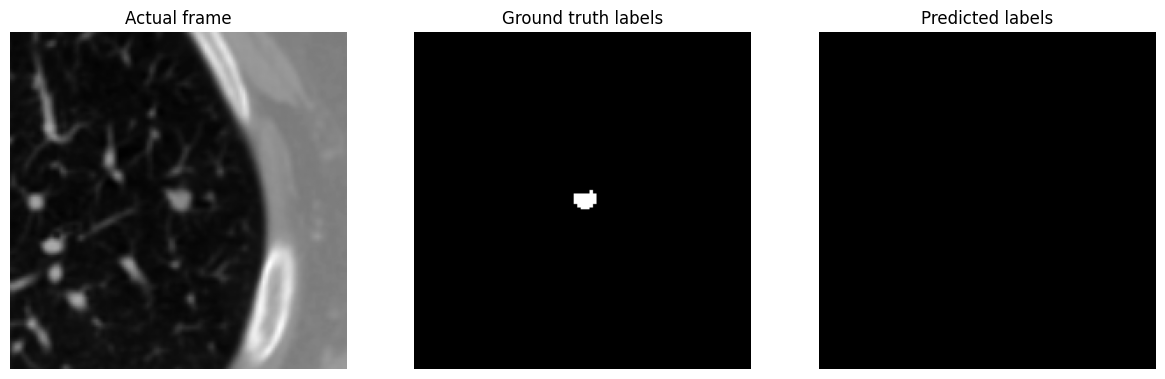

(192, 192, 1)


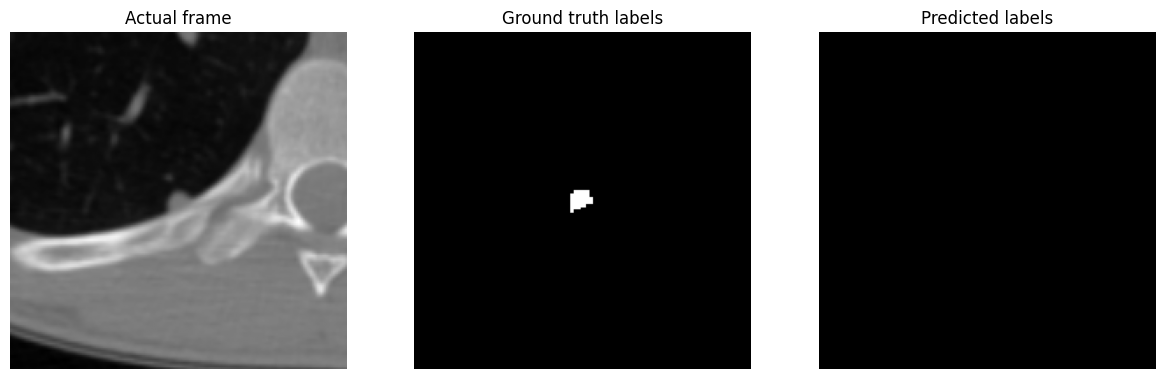

(192, 192, 1)


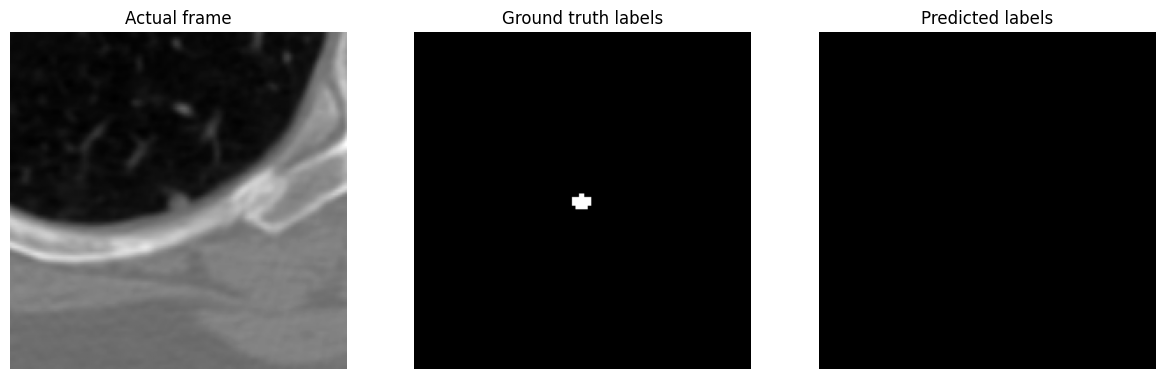

(192, 192, 1)


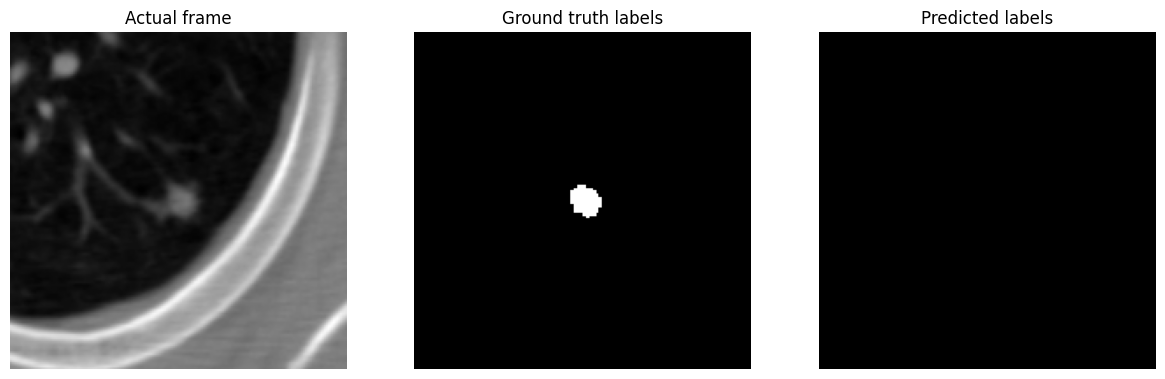

(192, 192, 1)


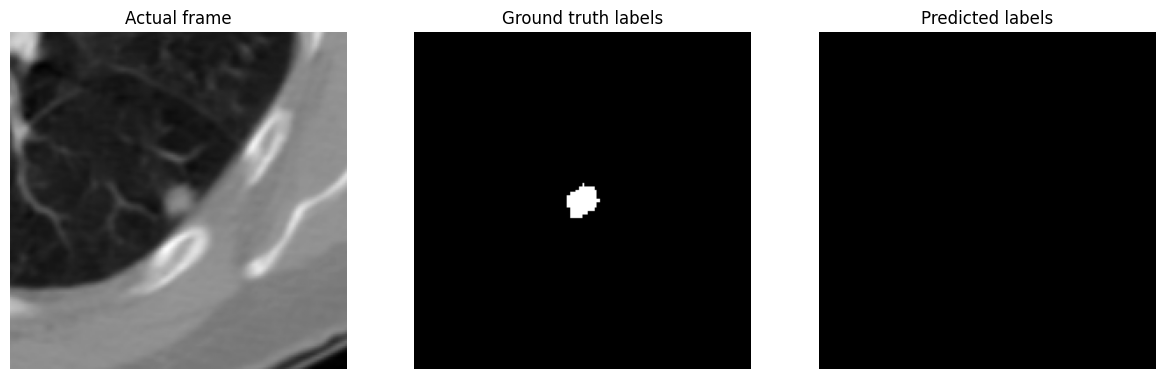

(192, 192, 1)


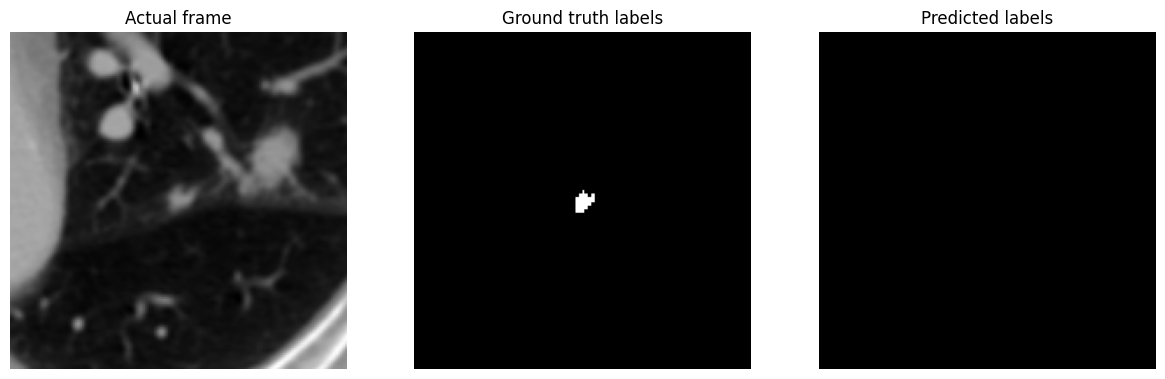

(192, 192, 1)


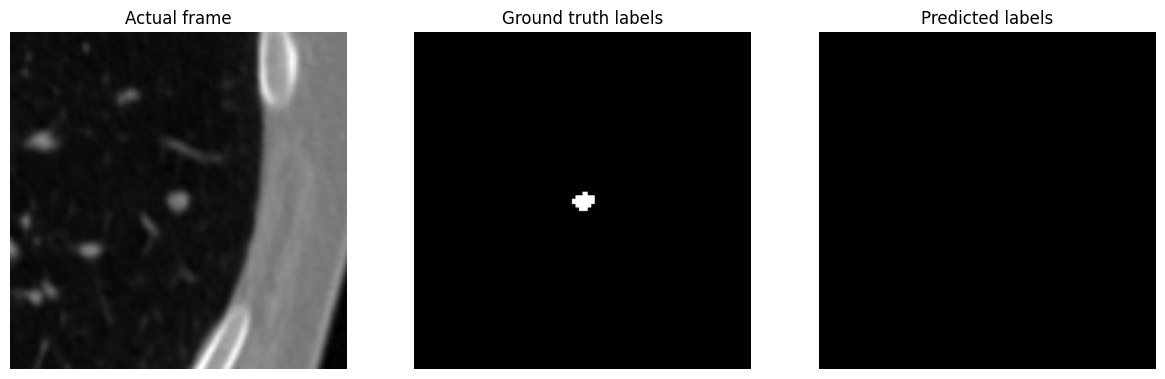

(192, 192, 1)


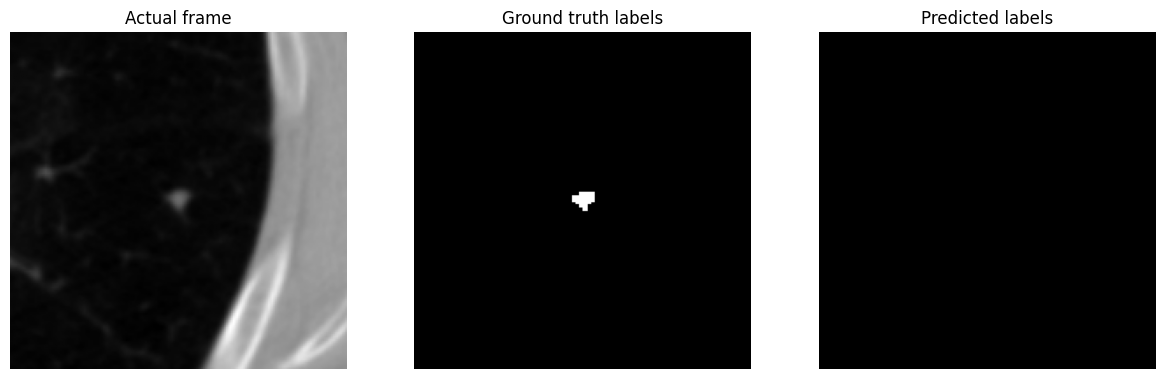

(192, 192, 1)


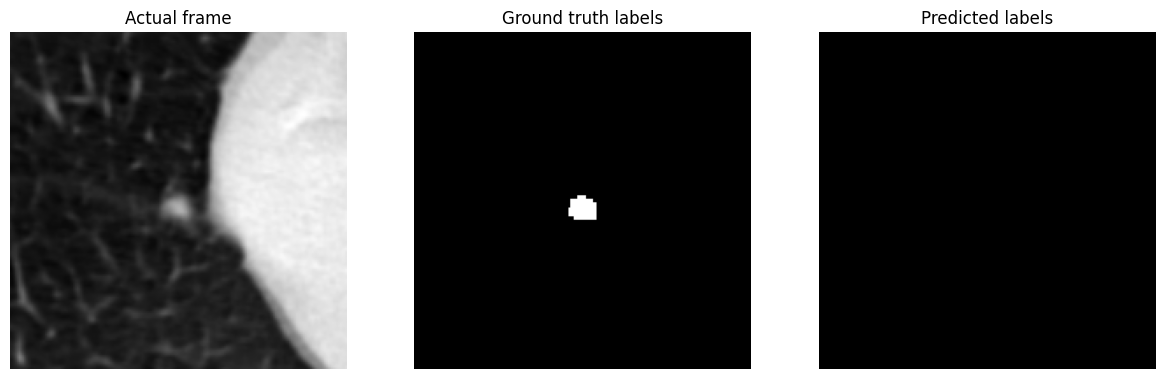

(192, 192, 1)


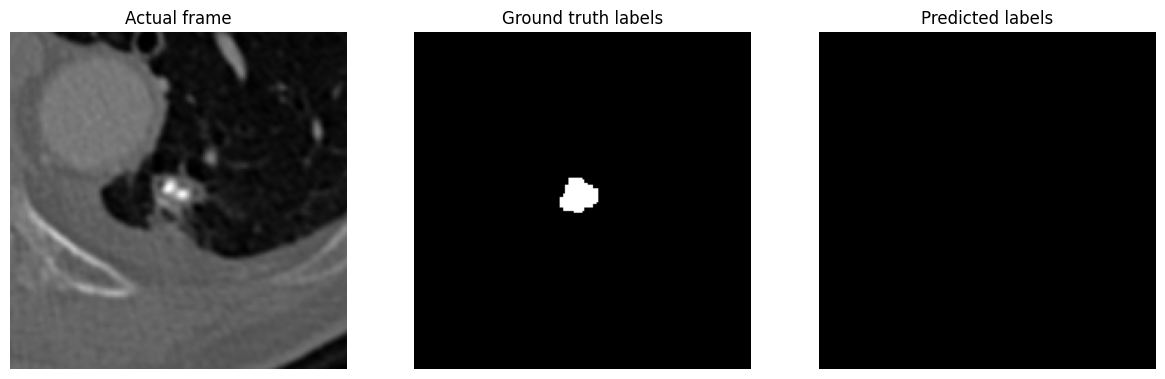

(192, 192, 1)


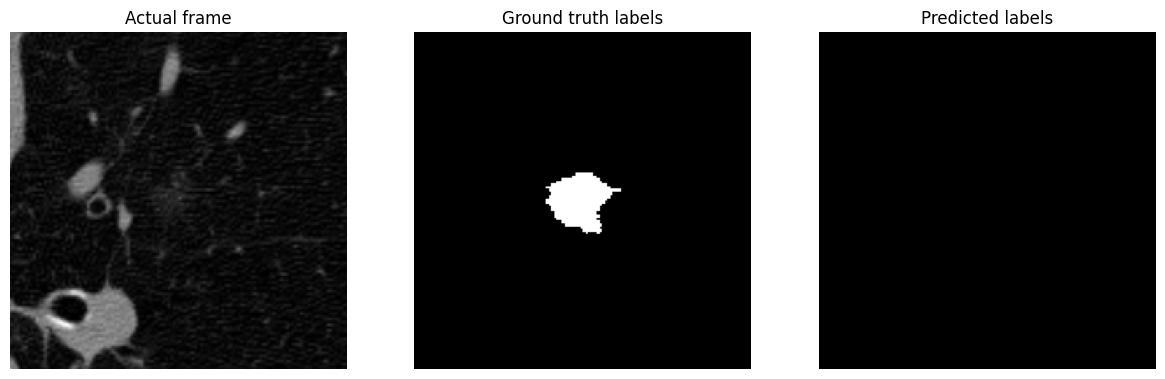

(192, 192, 1)


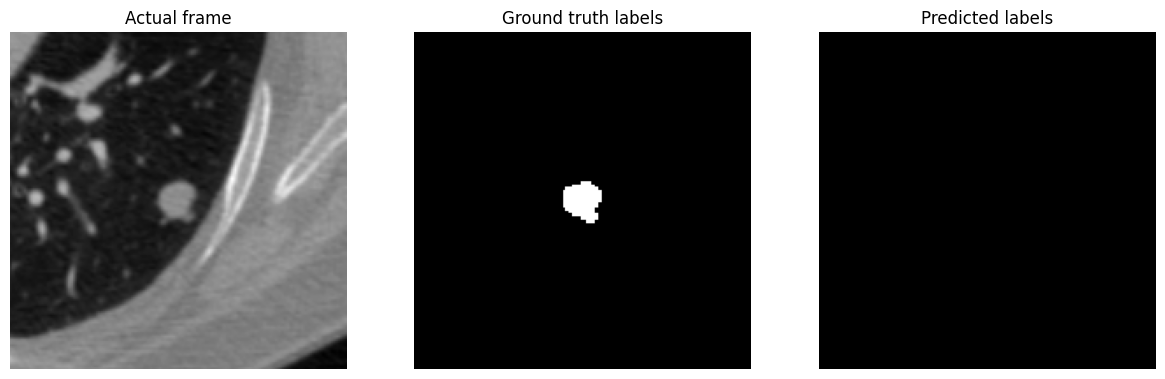

(192, 192, 1)


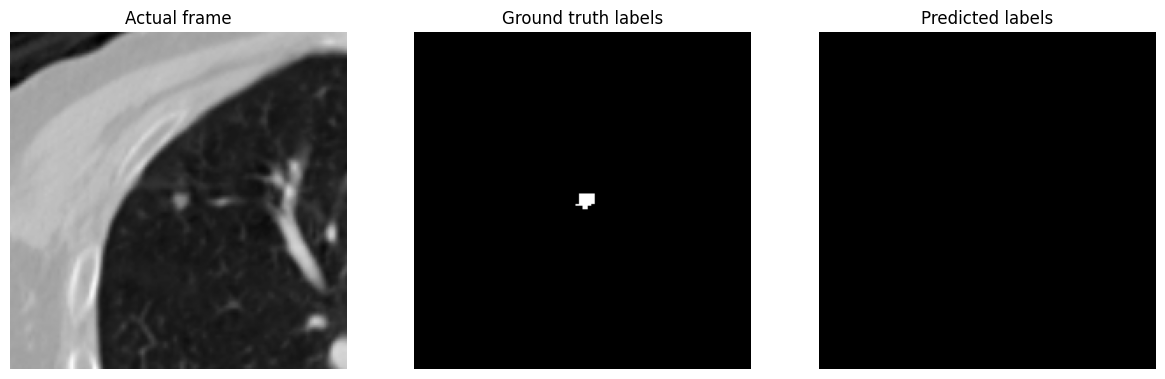

(192, 192, 1)


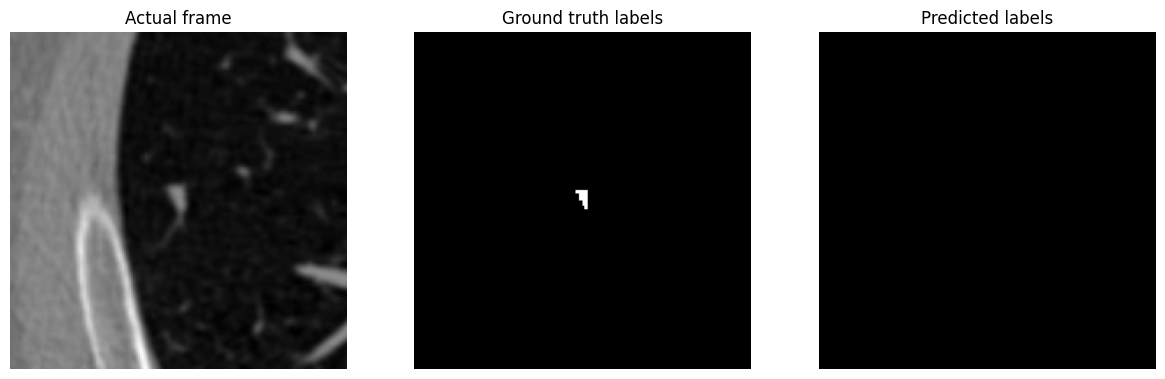

(192, 192, 1)


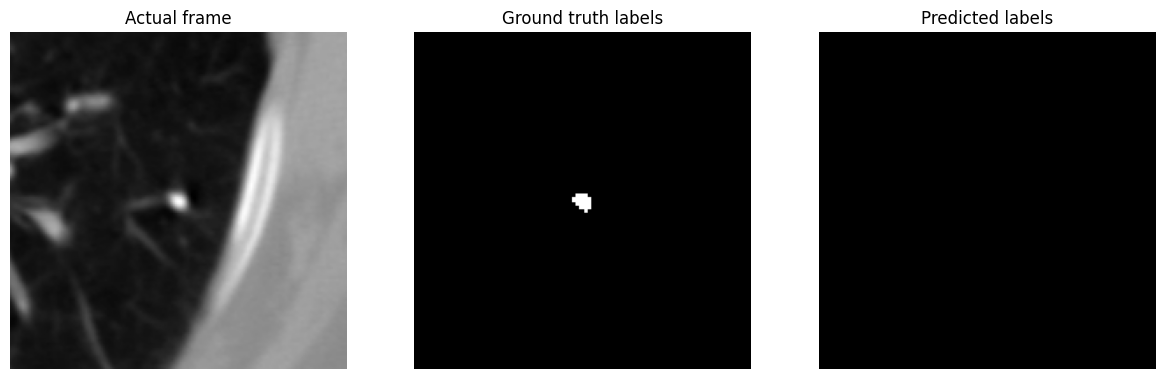

(192, 192, 1)


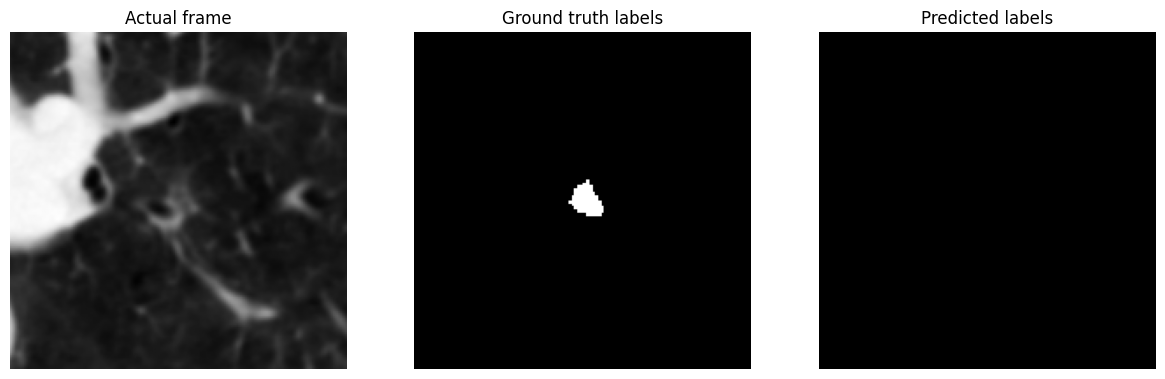

(192, 192, 1)


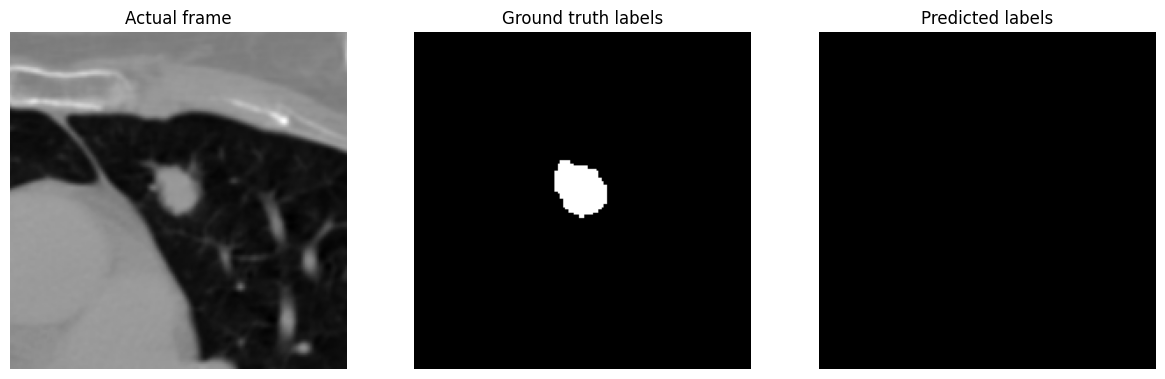

(192, 192, 1)


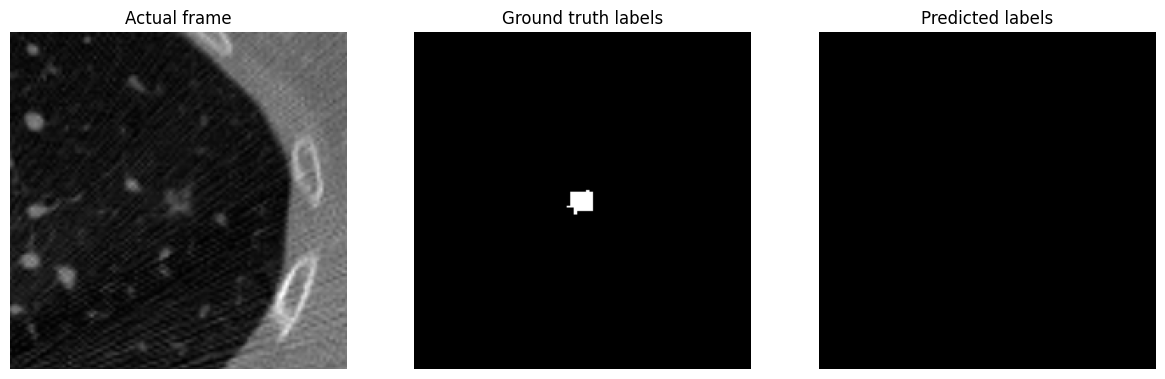

(192, 192, 1)


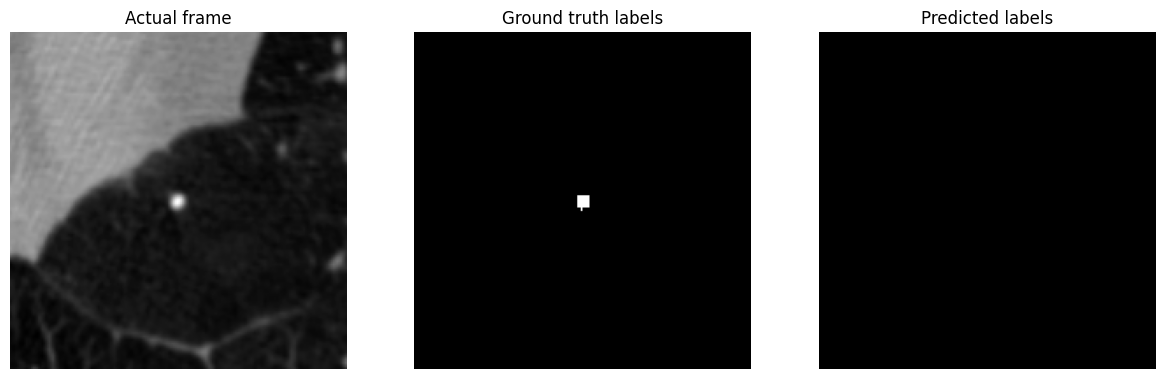

(192, 192, 1)


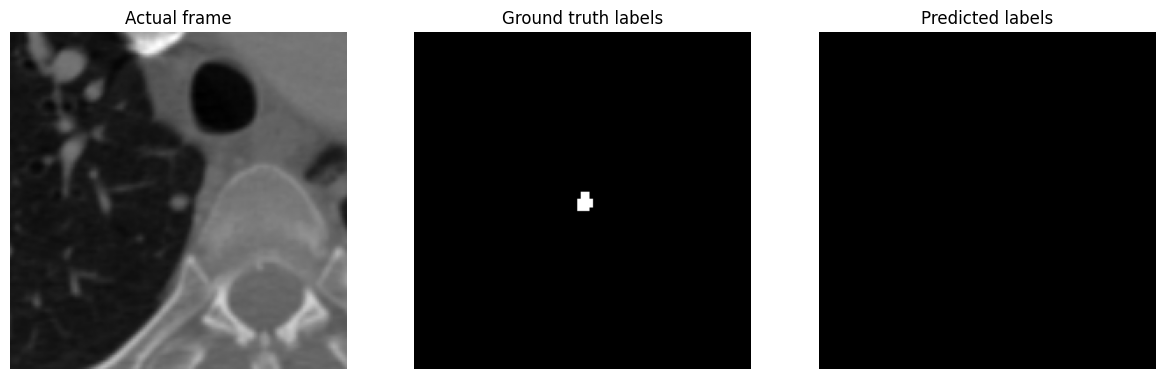

(192, 192, 1)


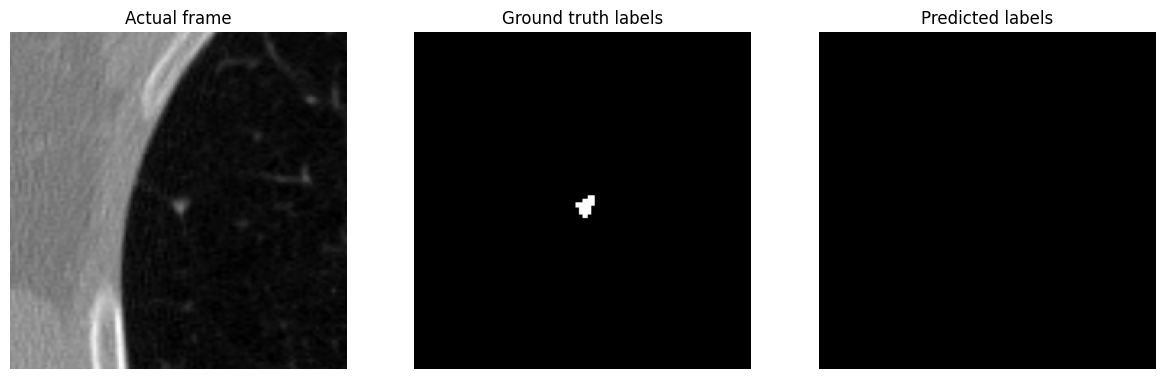

(192, 192, 1)


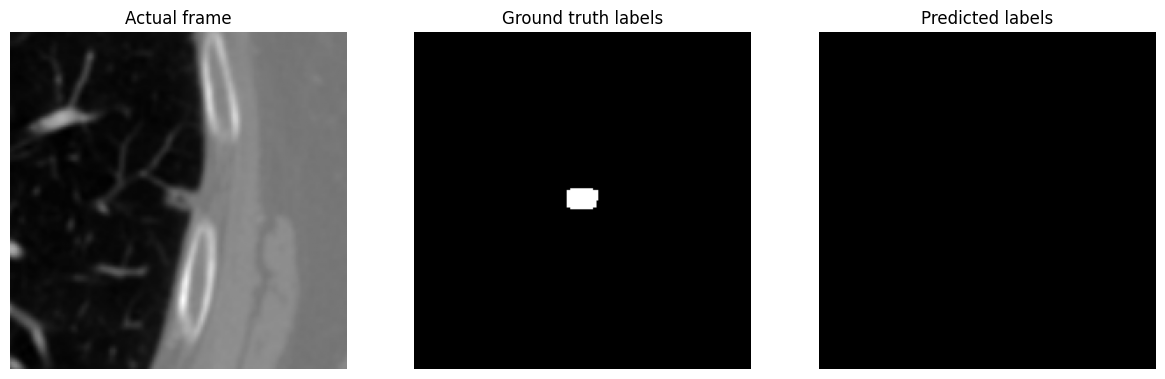

(192, 192, 1)


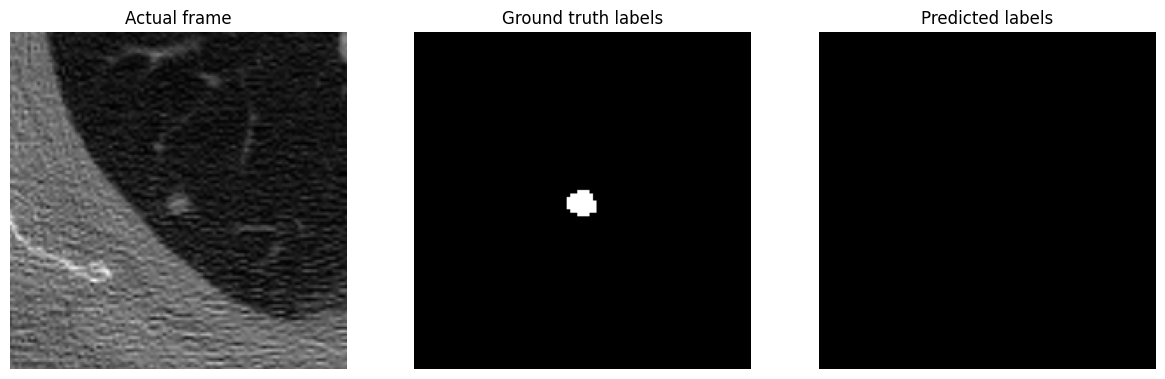

(192, 192, 1)


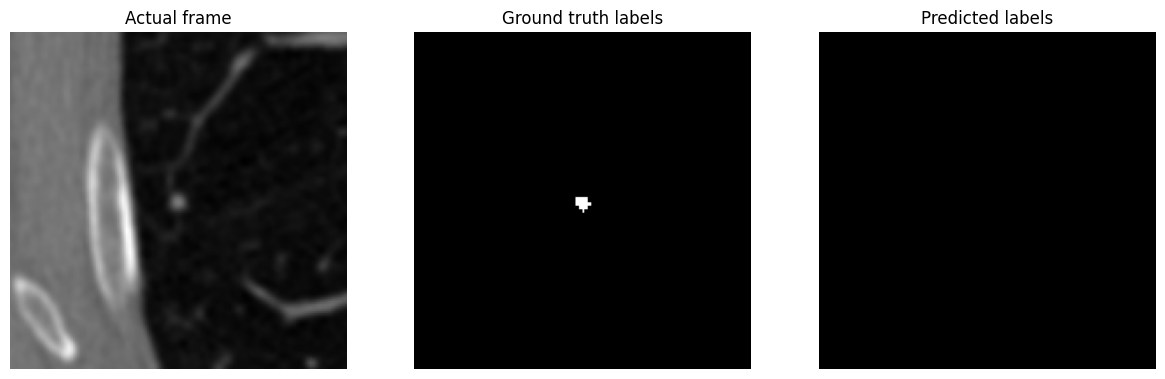

(192, 192, 1)


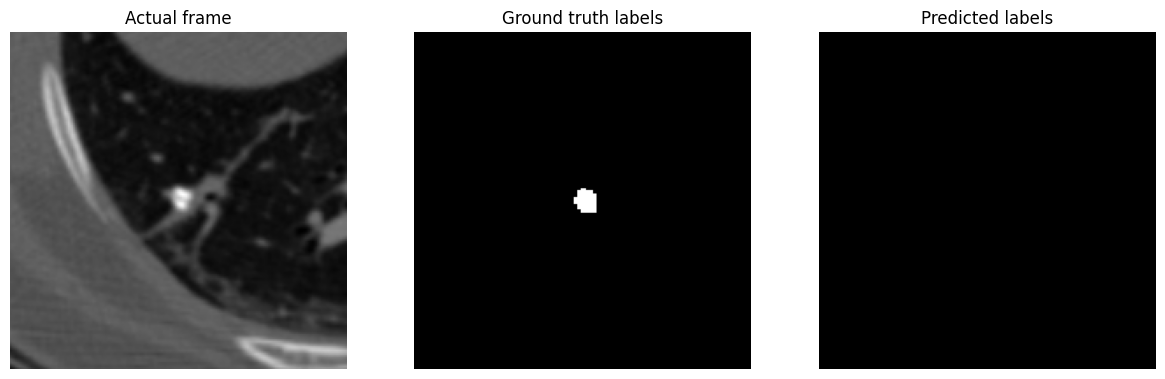

(192, 192, 1)


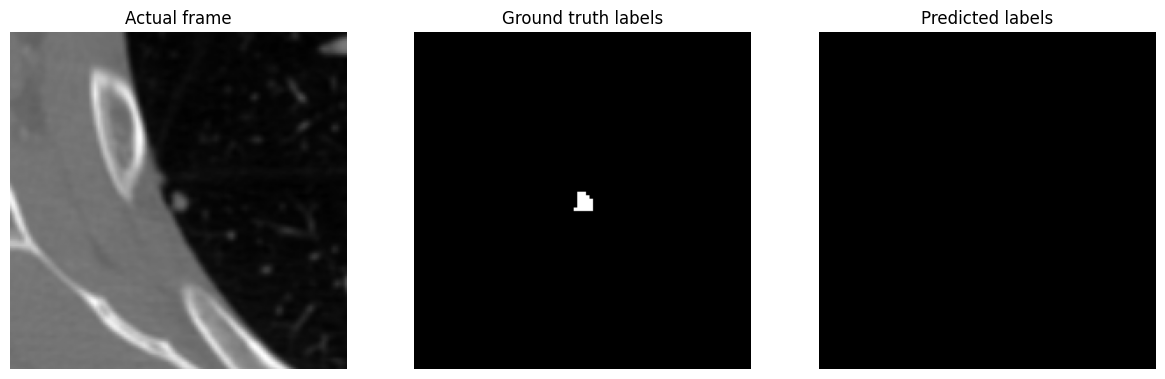

(192, 192, 1)


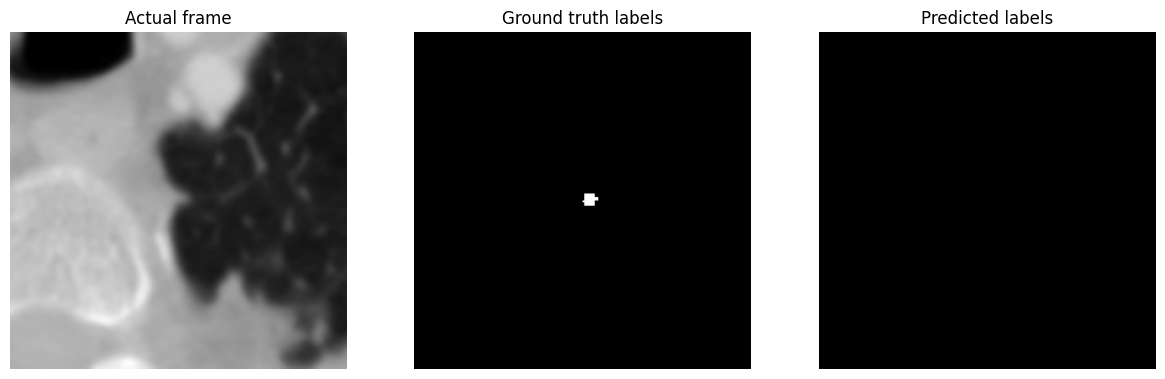

(192, 192, 1)


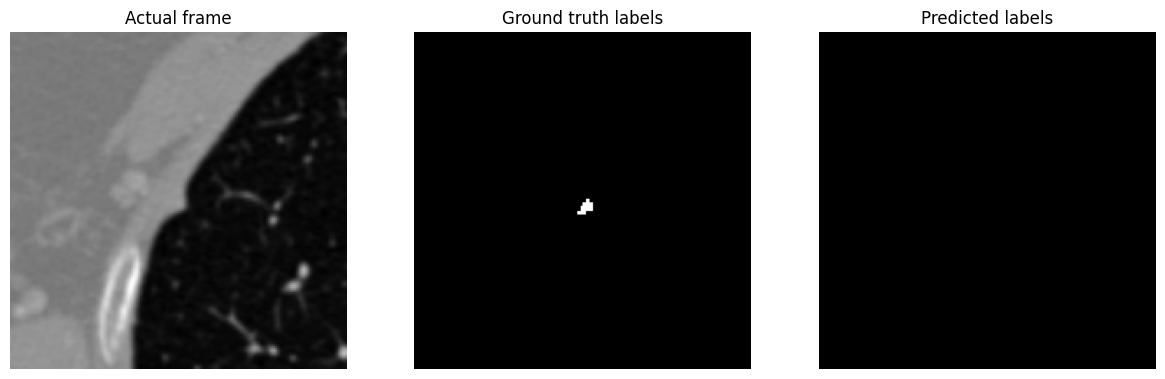

In [17]:
inference(model, test_dataset)